# Patterns and projections

## Patterns

In [1]:
from vectorbtpro import *
# whats_imported()

vbt.settings.set_theme("dark")

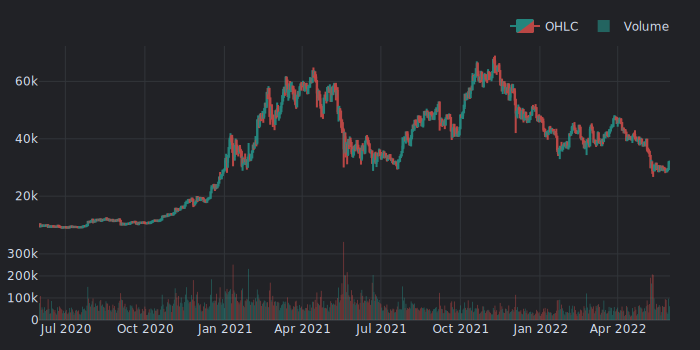

In [2]:
data = vbt.BinanceData.pull(
    "BTCUSDT", 
    start="2020-06-01 UTC", 
    end="2022-06-01 UTC"
)
data.plot().show_svg()

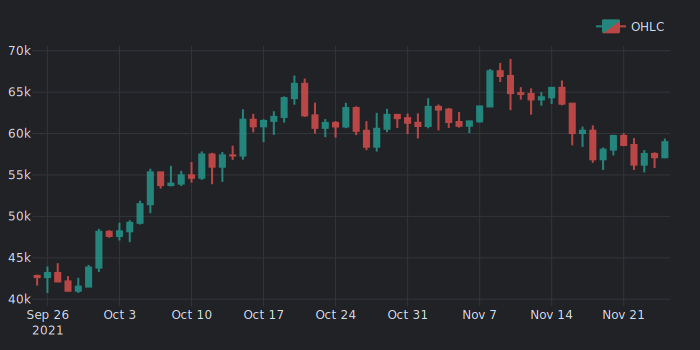

In [3]:
data_window = data.loc["2021-09-25":"2021-11-25"]
data_window.plot(plot_volume=False).show_svg()

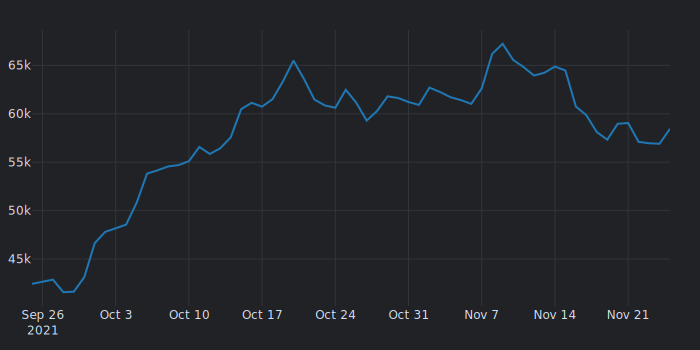

In [4]:
price_window = data_window.hlc3
price_window.vbt.plot().show_svg()

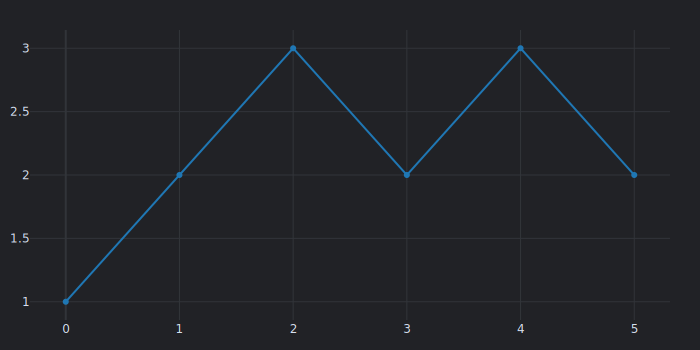

In [5]:
pattern = np.array([1, 2, 3, 2, 3, 2])
pd.Series(pattern).vbt.plot().show_svg()

### Interpolation

#### Linear

In [6]:
resized_pattern = vbt.nb.interp_resize_1d_nb(
    pattern, 10, vbt.enums.InterpMode.Linear
)
resized_pattern

array([1.        , 1.55555556, 2.11111111, 2.66666667, 2.77777778,
       2.22222222, 2.33333333, 2.88888889, 2.55555556, 2.        ])

In [7]:
def plot_linear(n):
    resized_pattern = vbt.nb.interp_resize_1d_nb(
        pattern, n, vbt.enums.InterpMode.Linear
    )
    return pd.Series(resized_pattern).vbt.plot()

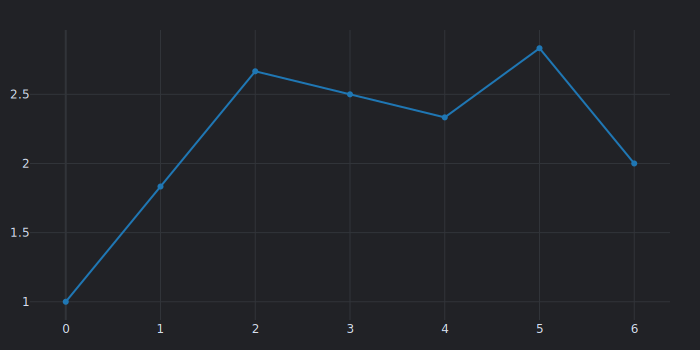

In [8]:
plot_linear(7).show_svg()

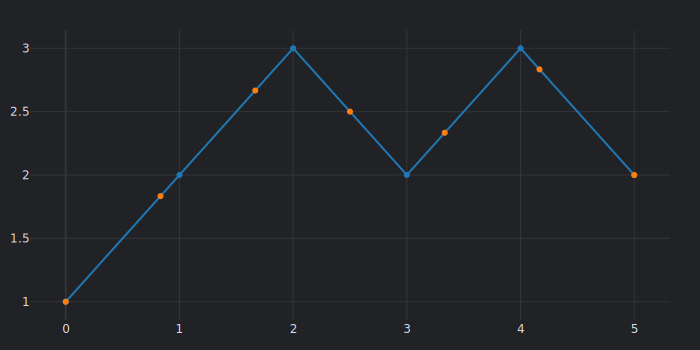

In [9]:
resized_pattern = vbt.nb.interp_resize_1d_nb(
    pattern, 7, vbt.enums.InterpMode.Linear
)
ratio = (len(pattern) - 1) / (len(resized_pattern) - 1)
new_points = np.arange(len(resized_pattern)) * ratio
fig = pd.Series(pattern).vbt.plot()
pd.Series(resized_pattern, index=new_points).vbt.scatterplot(fig=fig).show_svg()

#### Nearest

In [10]:
resized_pattern = vbt.nb.interp_resize_1d_nb(
    pattern, 10, vbt.enums.InterpMode.Nearest
)
resized_pattern

array([1., 2., 2., 3., 3., 2., 2., 3., 3., 2.])

In [11]:
def plot_nearest(n):
    resized_pattern = vbt.nb.interp_resize_1d_nb(
        pattern, n, vbt.enums.InterpMode.Nearest
    )
    return pd.Series(resized_pattern).vbt.plot()

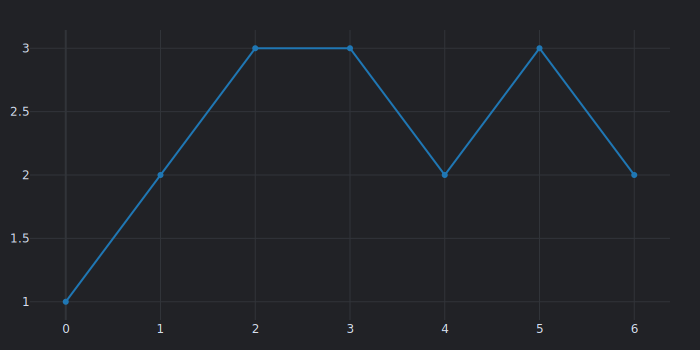

In [12]:
plot_nearest(7).show_svg()

#### Discrete

In [13]:
resized_pattern = vbt.nb.interp_resize_1d_nb(
    pattern, 10, vbt.enums.InterpMode.Discrete
)
resized_pattern

array([ 1., nan,  2., nan,  3.,  2., nan,  3., nan,  2.])

In [14]:
def plot_discrete(n):
    resized_pattern = vbt.nb.interp_resize_1d_nb(
        pattern, n, vbt.enums.InterpMode.Discrete
    )
    return pd.Series(resized_pattern).vbt.plot(
        trace_kwargs=dict(
            line=dict(dash="dot"), 
            connectgaps=True
        )
    )

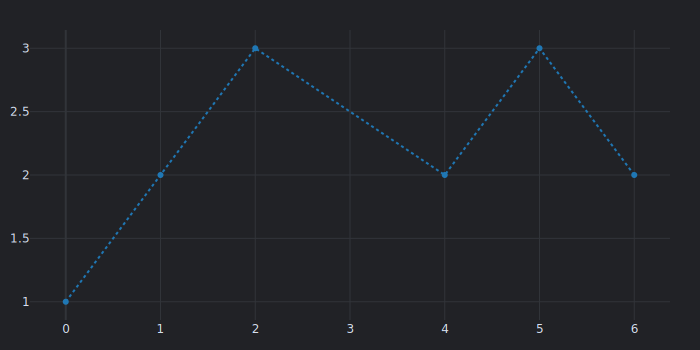

In [15]:
plot_discrete(7).show_svg()

#### Mixed

In [16]:
resized_pattern = vbt.nb.interp_resize_1d_nb(
    pattern, 10, vbt.enums.InterpMode.Mixed
)
resized_pattern

array([1.        , 1.55555556, 2.        , 2.66666667, 3.        ,
       2.        , 2.33333333, 3.        , 2.55555556, 2.        ])

In [17]:
def plot_mixed(n):
    lin_resized_pattern = vbt.nb.interp_resize_1d_nb(
        pattern, n, vbt.enums.InterpMode.Linear
    )
    mix_resized_pattern = vbt.nb.interp_resize_1d_nb(
        pattern, n, vbt.enums.InterpMode.Mixed
    )
    fig = pd.Series(lin_resized_pattern, name="Linear").vbt.plot()
    return pd.Series(mix_resized_pattern, name="Mixed").vbt.plot(fig=fig)

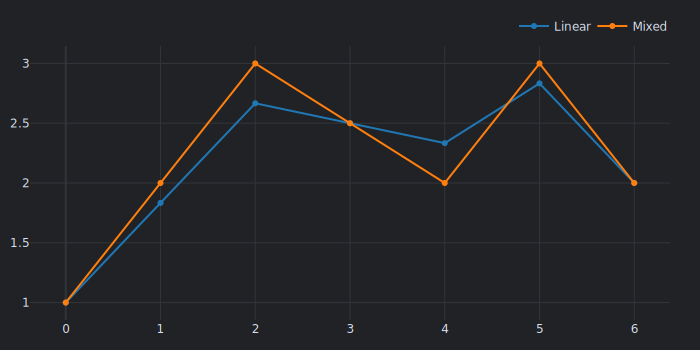

In [18]:
plot_mixed(7).show_svg()

In [19]:
resized_pattern = vbt.nb.interp_resize_1d_nb(
    pattern, len(price_window), vbt.enums.InterpMode.Mixed
)
resized_pattern.shape

(62,)

### Rescaling

In [20]:
pattern_scale = (resized_pattern.min(), resized_pattern.max())
price_window_scale = (price_window.min(), price_window.max())
rescaled_pattern = vbt.utils.array_.rescale_nb(
    resized_pattern, pattern_scale, price_window_scale
)
rescaled_pattern = pd.Series(rescaled_pattern, index=price_window.index)

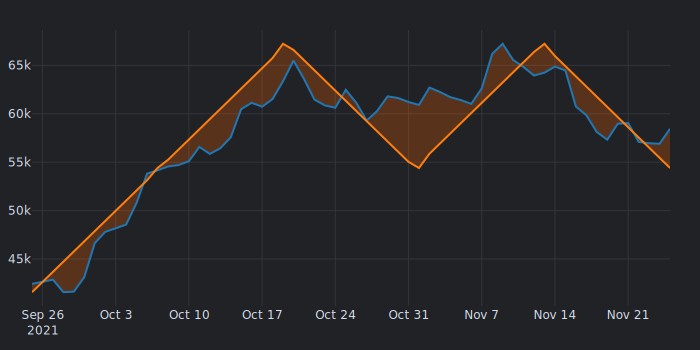

In [21]:
fig = price_window.vbt.plot()
rescaled_pattern.vbt.plot(
    trace_kwargs=dict(
        fill="tonexty", 
        fillcolor="rgba(255, 100, 0, 0.25)"
    ), 
    fig=fig
).show_svg()

#### Rebasing

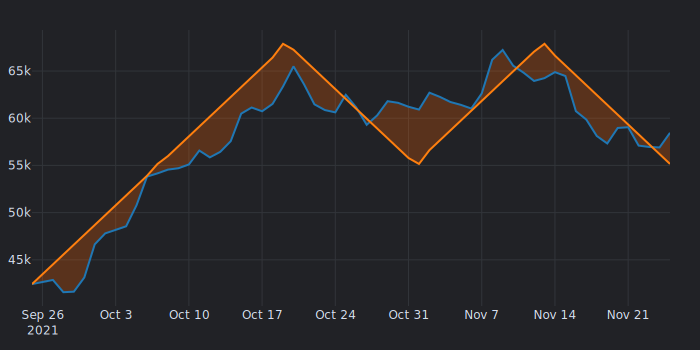

In [22]:
pct_pattern = np.array([1, 1.3, 1.6, 1.3, 1.6, 1.3])
resized_pct_pattern = vbt.nb.interp_resize_1d_nb(
    pct_pattern, len(price_window), vbt.enums.InterpMode.Mixed
)
rebased_pattern = resized_pct_pattern / resized_pct_pattern[0]
rebased_pattern *= price_window.values[0]
rebased_pattern = pd.Series(rebased_pattern, index=price_window.index)
fig = price_window.vbt.plot()
rebased_pattern.vbt.plot(
    trace_kwargs=dict(
        fill="tonexty", 
        fillcolor="rgba(255, 100, 0, 0.25)"
    ), 
    fig=fig
).show_svg()

### Similarity

In [23]:
abs_distances = np.abs(rescaled_pattern - price_window.values)
mae = abs_distances.sum()
max_abs_distances = np.column_stack((
    (price_window.max() - rescaled_pattern), 
    (rescaled_pattern - price_window.min())
)).max(axis=1)
max_mae = max_abs_distances.sum()
similarity = 1 - mae / max_mae
similarity

0.8726845123416802

In [24]:
quad_distances = (rescaled_pattern - price_window.values) ** 2
rmse = np.sqrt(quad_distances.sum())
max_quad_distances = np.column_stack((
    (price_window.max() - rescaled_pattern), 
    (rescaled_pattern - price_window.min())
)).max(axis=1) ** 2
max_rmse = np.sqrt(max_quad_distances.sum())
similarity = 1 - rmse / max_rmse
similarity

0.8484851233108504

In [25]:
quad_distances = (rescaled_pattern - price_window.values) ** 2
mse = quad_distances.sum()
max_quad_distances = np.column_stack((
    (price_window.max() - rescaled_pattern), 
    (rescaled_pattern - price_window.min())
)).max(axis=1) ** 2
max_mse = max_quad_distances.sum()
similarity = 1 - mse / max_mse
similarity

0.9770432421418718

In [26]:
vbt.nb.pattern_similarity_nb(price_window.values, pattern)

0.8726845123416802

In [27]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pct_pattern, 
    rescale_mode=vbt.enums.RescaleMode.Rebase
)

0.8647140967291362

In [28]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pct_pattern, 
    interp_mode=vbt.enums.InterpMode.Nearest,
    rescale_mode=vbt.enums.RescaleMode.Rebase,
    distance_measure=vbt.enums.DistanceMeasure.RMSE
)

0.76151009787845

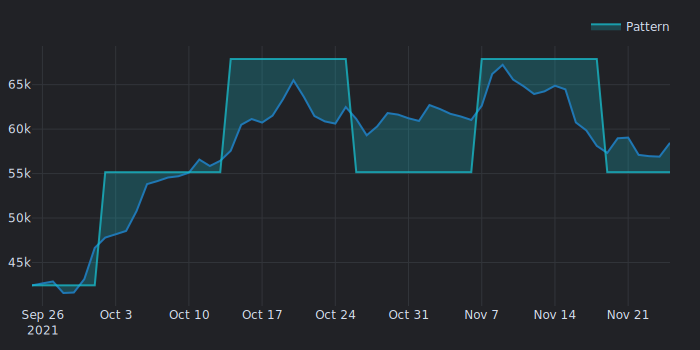

In [29]:
price_window.vbt.plot_pattern(
    pct_pattern, 
    interp_mode="nearest",
    rescale_mode="rebase",
    fill_distance=True
).show_svg()

In [30]:
adj_pct_pattern = np.array([1, 1.3, 1.6, 1.45, 1.6, 1.3])
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    adj_pct_pattern, 
    interp_mode=vbt.enums.InterpMode.Nearest,
    rescale_mode=vbt.enums.RescaleMode.Rebase,
    distance_measure=vbt.enums.DistanceMeasure.RMSE
)

0.8086016654243109

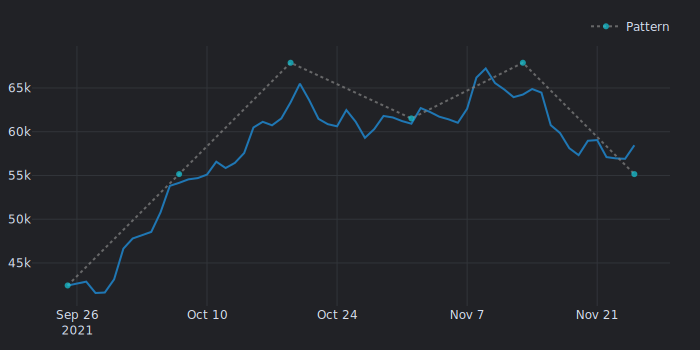

In [31]:
price_window.vbt.plot_pattern(
    adj_pct_pattern, 
    interp_mode="discrete",
    rescale_mode="rebase",
).show_svg()

In [32]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    adj_pct_pattern, 
    interp_mode=vbt.enums.InterpMode.Discrete,
    rescale_mode=vbt.enums.RescaleMode.Rebase,
    distance_measure=vbt.enums.DistanceMeasure.RMSE
)

0.8719692914480557

#### Relative

In [33]:
abs_pct_distances = abs_distances / rescaled_pattern
pct_mae = abs_pct_distances.sum()
max_abs_pct_distances = max_abs_distances / rescaled_pattern
max_pct_mae = max_abs_pct_distances.sum()
similarity = 1 - pct_mae / max_pct_mae
similarity

0.8732697724295595

In [34]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pct_pattern, 
    error_type=vbt.enums.ErrorType.Relative
)

0.8732697724295594

In [35]:
vbt.nb.pattern_similarity_nb(
    np.array([10, 30, 100]),
    np.array([1, 2, 3]),
    error_type=vbt.enums.ErrorType.Absolute
)

0.8888888888888888

In [36]:
vbt.nb.pattern_similarity_nb(
    np.array([10, 30, 100]),
    np.array([1, 2, 3]),
    error_type=vbt.enums.ErrorType.Relative
)

0.9575911789652247

#### Inverse

In [37]:
vbt.nb.pattern_similarity_nb(price_window.values, pattern, invert=True)

0.32064009029620244

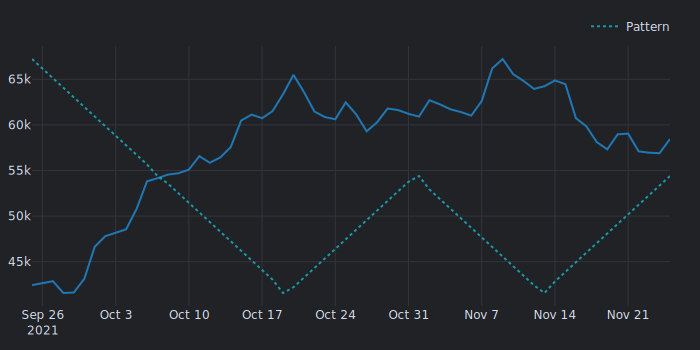

In [38]:
price_window.vbt.plot_pattern(pattern, invert=True).show_svg()

In [39]:
pattern.max() + pattern.min() - pattern

array([3, 2, 1, 2, 1, 2])

#### Max error

In [40]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pattern,
)

0.8726845123416802

In [41]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pattern, 
    max_error=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
)

0.8611332262389184

In [42]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pattern, 
    max_error=np.array([0.5]),
)

0.8611332262389184

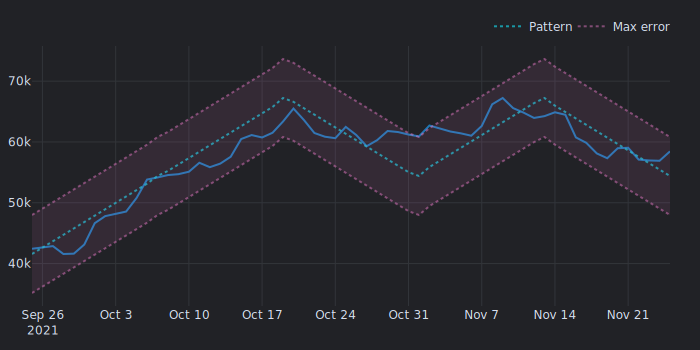

In [43]:
price_window.vbt.plot_pattern(
    pattern, 
    max_error=0.5
).show_svg()

In [44]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pattern, 
    max_error=np.array([0.5]),
    max_error_strict=True
)

nan

In [45]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    adj_pct_pattern, 
    rescale_mode=vbt.enums.RescaleMode.Rebase,
    max_error=np.array([0.2, 0.1, 0.05, 0.1, 0.05, 0.1]),
    max_error_strict=True
)

nan

In [46]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pattern, 
    max_error=np.array([0.1]),
    error_type=vbt.enums.ErrorType.Relative
)

0.8548520433078988

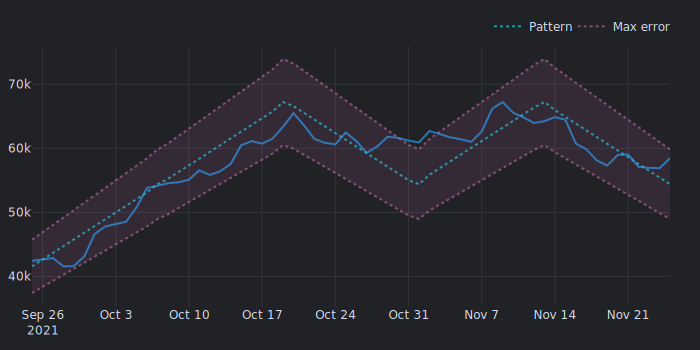

In [47]:
price_window.vbt.plot_pattern(
    pattern, 
    max_error=0.1,
    error_type="relative"
).show_svg()

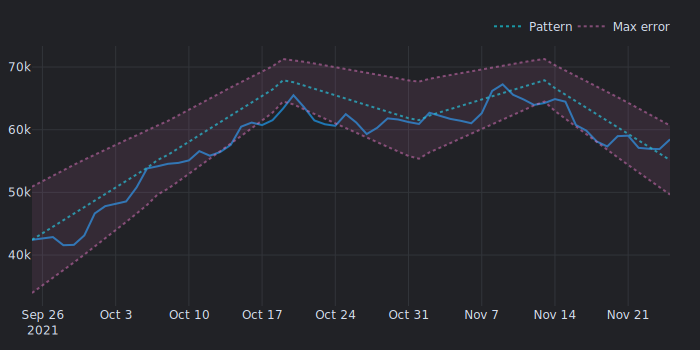

In [48]:
price_window.vbt.plot_pattern(
    adj_pct_pattern, 
    rescale_mode="rebase",
    max_error=np.array([0.2, 0.1, 0.05, 0.1, 0.05, 0.1])
).show_svg()

In [49]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    adj_pct_pattern, 
    rescale_mode=vbt.enums.RescaleMode.Rebase,
    max_error=np.array([0.2, 0.1, 0.05, 0.1, 0.05, 0.1]) + 0.05,
    max_error_strict=True
)

0.8789689066239321

##### Interpolation

In [50]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    adj_pct_pattern, 
    rescale_mode=vbt.enums.RescaleMode.Rebase,
    max_error=np.array([np.nan, np.nan, 0.1, np.nan, 0.1, np.nan]),
    max_error_interp_mode=vbt.enums.InterpMode.Discrete,
    max_error_strict=True
)

0.8789689066239321

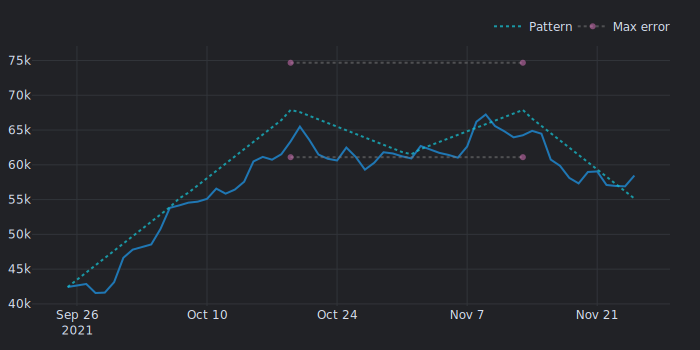

In [51]:
price_window.vbt.plot_pattern(
    adj_pct_pattern, 
    rescale_mode="rebase",
    max_error=np.array([np.nan, np.nan, 0.1, np.nan, 0.1, np.nan]),
    max_error_interp_mode="discrete"
).show_svg()

##### Max distance

In [52]:
vbt.nb.pattern_similarity_nb(price_window.values, pattern)

0.8726845123416802

In [53]:
vbt.nb.pattern_similarity_nb(
    price_window.values, 
    pattern, 
    max_error=np.array([0.5]),
    max_error_as_maxdist=True
)

0.6193594883412921

#### Further filters

In [54]:
vbt.nb.pattern_similarity_nb(price_window.values, pattern, max_pct_change=0.3)

nan

In [55]:
vbt.nb.pattern_similarity_nb(price_window.values, pattern, min_similarity=0.9)

nan

### Rolling similarity

In [56]:
price = data.hlc3

similarity = price.vbt.rolling_pattern_similarity(
    pattern, 
    window=30,
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete"
)
similarity.describe()

count    701.000000
mean       0.499321
std        0.144088
min        0.148387
25%        0.394584
50%        0.502231
75%        0.607962
max        0.838393
dtype: float64

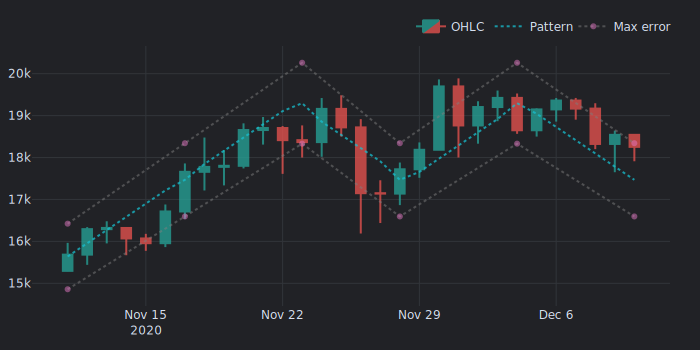

In [57]:
end_row = similarity.argmax() + 1
start_row = end_row - 30
fig = data.iloc[start_row:end_row].plot(plot_volume=False)
price.iloc[start_row:end_row].vbt.plot_pattern(
    pattern, 
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete",
    plot_obj=False, 
    fig=fig
).show_svg()

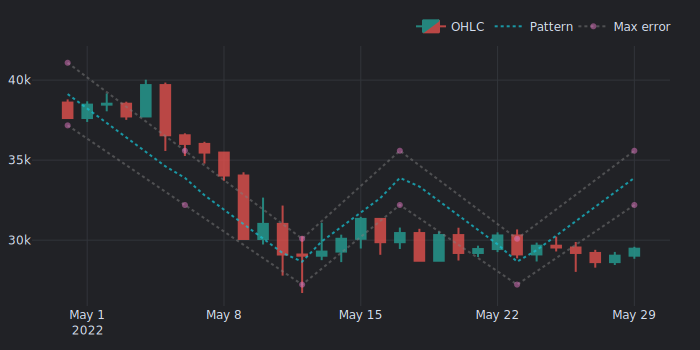

In [58]:
end_row = similarity.argmin() + 1
start_row = end_row - 30
fig = data.iloc[start_row:end_row].plot(plot_volume=False)
price.iloc[start_row:end_row].vbt.plot_pattern(
    pattern, 
    invert=True,
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete",
    plot_obj=False, 
    fig=fig
).show_svg()

In [59]:
inv_similarity = price.vbt.rolling_pattern_similarity(
    pattern, 
    window=30,
    invert=True,
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete"
)
inv_similarity.describe()

count    701.000000
mean       0.498256
std        0.134973
min        0.176922
25%        0.394272
50%        0.492906
75%        0.593783
max        0.812079
dtype: float64

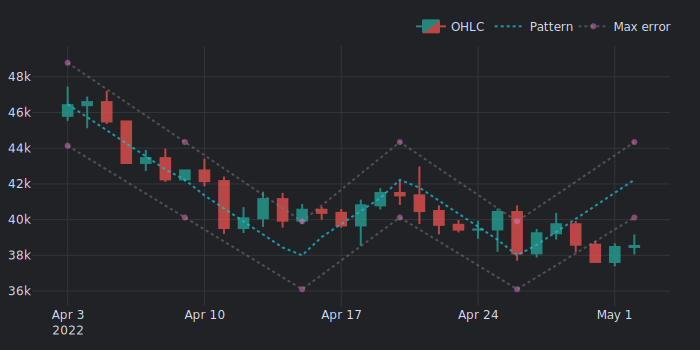

In [60]:
end_row = inv_similarity.argmax() + 1
start_row = end_row - 30
fig = data.iloc[start_row:end_row].plot(plot_volume=False)
price.iloc[start_row:end_row].vbt.plot_pattern(
    pattern, 
    invert=True,
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete",
    plot_obj=False, 
    fig=fig
).show_svg()

#### Indicator

In [61]:
patsim = vbt.PATSIM.run(
    price, 
    vbt.Default(pattern),
    error_type=vbt.Default("relative"),
    max_error=vbt.Default(0.05),
    max_error_interp_mode=vbt.Default("discrete"),
    window=[30, 45, 60, 75, 90]
)

In [62]:
patsim.wrapper.columns

Index([30, 45, 60, 75, 90], dtype='int64', name='patsim_window')

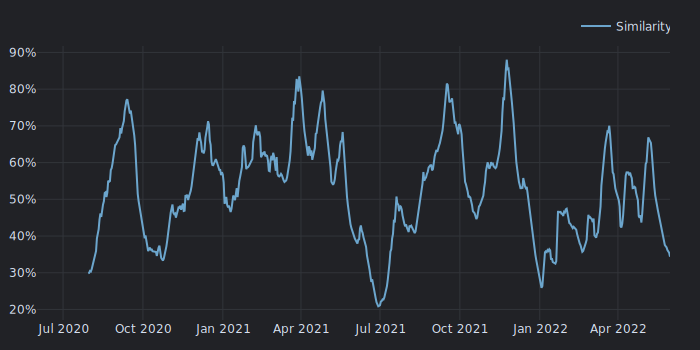

In [63]:
patsim.plot(column=60).show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



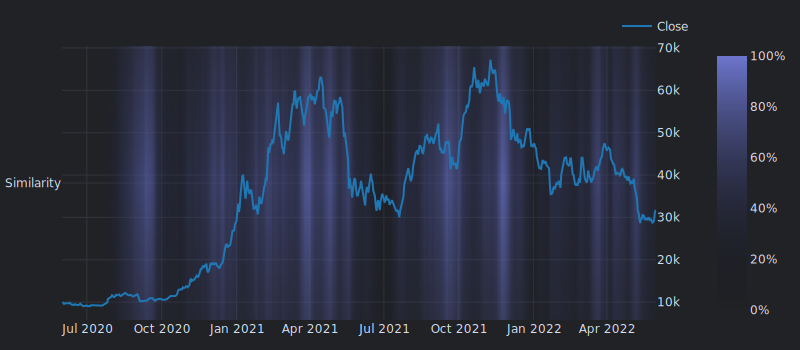

In [64]:
patsim.overlay_with_heatmap(column=60).show_svg()

In [65]:
exits = patsim.similarity >= 0.8
exits.sum()

patsim_window
30     6
45     8
60    14
75     0
90     5
dtype: int64

In [66]:
patsim = vbt.PATSIM.run(
    price, 
    vbt.Default(pattern),
    error_type=vbt.Default("relative"),
    max_error=vbt.Default(0.05),
    max_error_interp_mode=vbt.Default("discrete"),
    window=[30, 45, 60, 75, 90],
    invert=[False, True],
    min_similarity=[0.7, 0.8],
    param_product=True
)
exits = ~patsim.similarity.isnull()
exits.sum()

patsim_window  patsim_invert  patsim_min_similarity
30             False          0.7                      68
                              0.8                       6
               True           0.7                      64
                              0.8                       2
45             False          0.7                      83
                              0.8                       8
               True           0.7                      64
                              0.8                       0
60             False          0.7                      70
                              0.8                      14
               True           0.7                      39
                              0.8                       6
75             False          0.7                      86
                              0.8                       0
               True           0.7                      68
                              0.8                       4
90             False

In [67]:
groupby = [
    name for name in patsim.wrapper.columns.names 
    if name != "patsim_window"
]
max_sim = patsim.similarity.groupby(groupby, axis=1).max()
entries = ~max_sim.xs(True, level="patsim_invert", axis=1).isnull()
exits = ~max_sim.xs(False, level="patsim_invert", axis=1).isnull()

/tmp/ipykernel_433640/1603806719.py:5: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



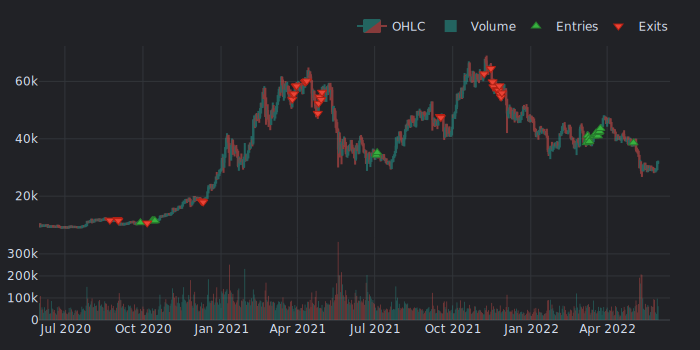

In [68]:
fig = data.plot(ohlc_trace_kwargs=dict(opacity=0.5))
entries[0.8].vbt.signals.plot_as_entries(price, fig=fig)
exits[0.8].vbt.signals.plot_as_exits(price, fig=fig).show_svg()

### Search

In [69]:
pattern_range_records = vbt.nb.find_pattern_1d_nb(
    price.values,
    pattern,
    window=30,
    max_window=90,
    error_type=vbt.enums.ErrorType.Relative,
    max_error=np.array([0.05]),
    max_error_interp_mode=vbt.enums.InterpMode.Discrete,
    min_similarity=0.85
)
pattern_range_records

array([(0, 0, 270, 314, 1, 0.86226468), (1, 0, 484, 540, 1, 0.89078042)],
      dtype={'names': ['id', 'col', 'start_idx', 'end_idx', 'status', 'similarity'], 'formats': ['<i8', '<i8', '<i8', '<i8', '<i8', '<f8'], 'offsets': [0, 8, 16, 24, 32, 40], 'itemsize': 48, 'aligned': True})

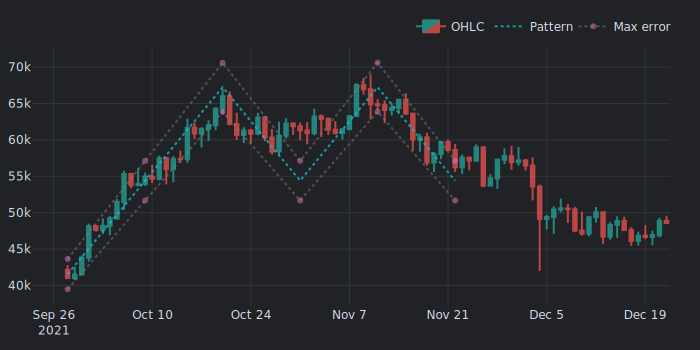

In [70]:
start_row = pattern_range_records[1]["start_idx"]
end_row = pattern_range_records[1]["end_idx"]
fig = data.iloc[start_row:end_row + 30].plot(plot_volume=False)
price.iloc[start_row:end_row].vbt.plot_pattern(
    pattern, 
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete",
    plot_obj=False, 
    fig=fig
).show_svg()

In [71]:
pattern_ranges = vbt.PatternRanges.from_pattern_search(
    price,
    pattern,
    window=30,
    max_window=120,
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete",
    min_similarity=0.85
)
pattern_ranges

In [72]:
pattern_ranges = price.vbt.find_pattern(
    pattern,
    window=30,
    max_window=90,
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete",
    min_similarity=0.85
)

In [73]:
print(pattern_ranges.records_readable)

   Pattern Range Id  Column               Start Index  \
0                 0       0 2021-02-26 00:00:00+00:00   
1                 1       0 2021-09-28 00:00:00+00:00   

                  End Index  Status  Similarity  
0 2021-04-11 00:00:00+00:00  Closed    0.862265  
1 2021-11-23 00:00:00+00:00  Closed    0.890780  


In [74]:
pattern_ranges.wrapper.columns

Index([0], dtype='int64')

In [75]:
pattern_ranges.search_configs

[PSC(pattern=array([1, 2, 3, 2, 3, 2]), window=30, max_window=90, row_select_prob=1.0, window_select_prob=1.0, roll_forward=False, interp_mode=3, rescale_mode=0, vmin=nan, vmax=nan, pmin=nan, pmax=nan, invert=False, error_type=1, distance_measure=0, max_error=array([0.05]), max_error_interp_mode=2, max_error_as_maxdist=False, max_error_strict=False, min_pct_change=nan, max_pct_change=nan, min_similarity=0.85, minp=None, overlap_mode=0, max_records=None, name=None)]

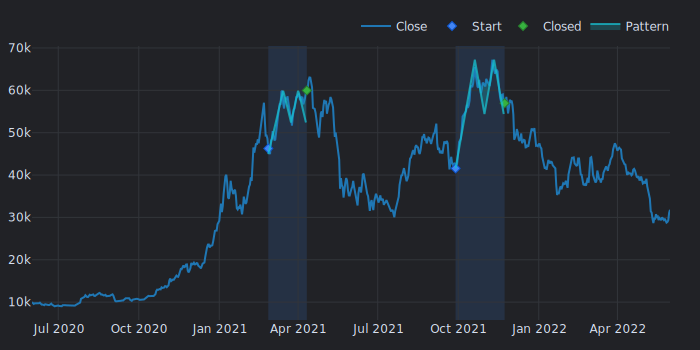

In [76]:
pattern_ranges.plot().show_svg()

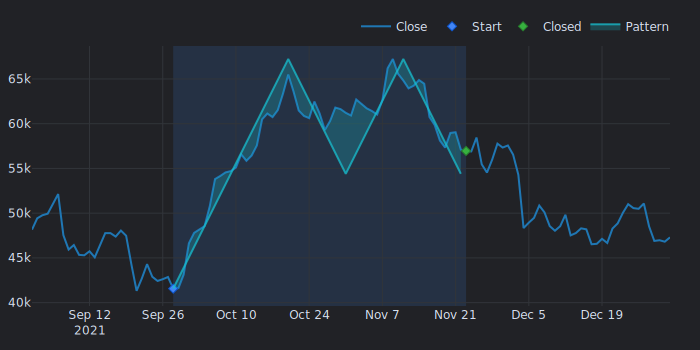

In [77]:
pattern_ranges.loc["2021-09-01":"2022-01-01"].plot().show_svg()

In [78]:
pattern_ranges.stats()

Start Index           2020-06-01 00:00:00+00:00
End Index             2022-05-31 00:00:00+00:00
Total Duration                730 days 00:00:00
Total Records                                 2
Coverage                               0.136986
Overlap Coverage                            0.0
Duration: Min                  44 days 00:00:00
Duration: Median               50 days 00:00:00
Duration: Max                  56 days 00:00:00
Similarity: Min                        0.862265
Similarity: Median                     0.876523
Similarity: Max                         0.89078
dtype: object

#### Overlapping

In [79]:
pattern_ranges = price.vbt.find_pattern(
    pattern,
    window=30,
    max_window=120,
    error_type="relative",
    max_error=0.05,
    max_error_interp_mode="discrete",
    min_similarity=0.85,
    overlap_mode="allow"
)

In [80]:
pattern_ranges.count()

16

In [81]:
pattern_ranges.overlap_coverage

0.9642857142857143

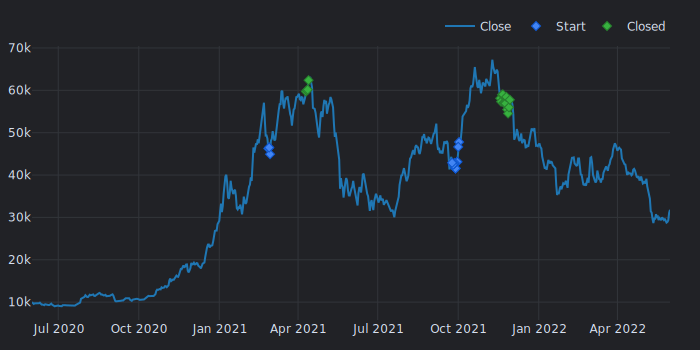

In [82]:
pattern_ranges.plot(plot_zones=False, plot_patterns=False).show_svg()

#### Random selection

In [83]:
def run_prob_search(row_select_prob, window_select_prob):
    return price.vbt.find_pattern(
        pattern,
        window=30,
        max_window=120,
        row_select_prob=row_select_prob,
        window_select_prob=window_select_prob,
        error_type="relative",
        max_error=0.05,
        max_error_interp_mode="discrete",
        min_similarity=0.8,
    )

In [84]:
%timeit run_prob_search(1.0, 1.0)

171 ms ± 6.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
%timeit run_prob_search(0.5, 0.25)

22.6 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
run_prob_search(1.0, 1.0).count()

6

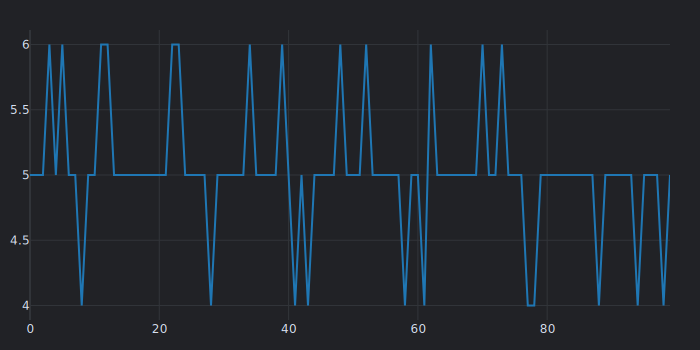

In [87]:
pd.Series([
    run_prob_search(0.5, 0.25).count() 
    for i in range(100)
]).vbt.plot().show_svg()

#### Params

In [88]:
pattern_ranges = price.vbt.find_pattern(
    vbt.Param([
        [1, 2, 1],
        [2, 1, 2],
        [1, 2, 3],
        [3, 2, 1]
    ]),
    window=30,
    max_window=120,
)

 25%|##5       | 1/4 [00:02<00:07,  2.49s/it, pattern=list_1]

In [89]:
pattern_ranges.count()

pattern
list_0    3
list_1    0
list_2    7
list_3    3
Name: count, dtype: int64

In [90]:
pattern_ranges = price.vbt.find_pattern(
    vbt.Param([
        [1, 2, 1],
        [2, 1, 2],
        [1, 2, 3],
        [3, 2, 1]
    ], keys=["v-top", "v-bottom", "rising", "falling"]),
    window=30,
    max_window=120,
)
pattern_ranges.count()

pattern
v-top       3
v-bottom    0
rising      7
falling     3
Name: count, dtype: int64

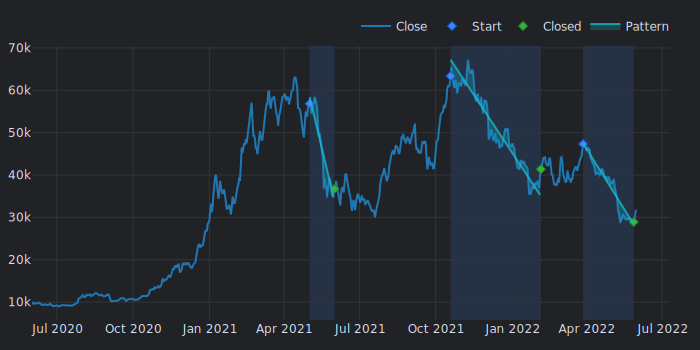

In [91]:
pattern_ranges.plot(column="falling").show_svg()

In [92]:
pattern_ranges = price.vbt.find_pattern(
    vbt.Param([
        [1, 2, 1],
        [2, 1, 2],
        [1, 2, 3],
        [3, 2, 1]
    ], keys=["v-top", "v-bottom", "rising", "falling"]),
    window=30,
    max_window=120,
    min_similarity=vbt.Param([0.8, 0.85])
)
pattern_ranges.count()

pattern   min_similarity
v-top     0.80              6
          0.85              3
v-bottom  0.80              3
          0.85              0
rising    0.80              8
          0.85              7
falling   0.80              6
          0.85              3
Name: count, dtype: int64

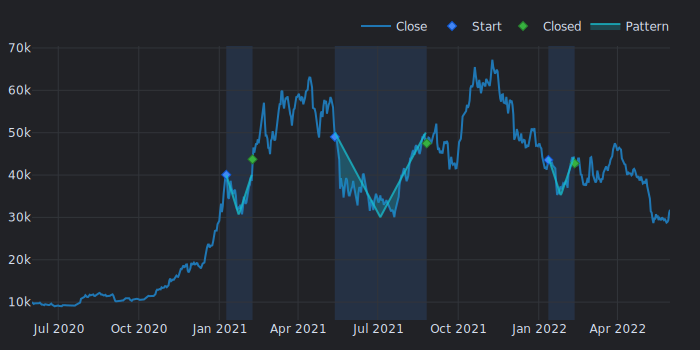

In [93]:
pattern_ranges.plot(column=("v-bottom", 0.8)).show_svg()

In [94]:
pattern_ranges = price.vbt.find_pattern(
    vbt.Param([
        [1, 2, 1],
        [2, 1, 2],
        [1, 2, 3],
        [3, 2, 1]
    ], keys=["v-top", "v-bottom", "rising", "falling"], level=0),
    window=vbt.Param([30, 30, 7, 7], level=0),
    max_window=vbt.Param([120, 120, 30, 30], level=0),
    min_similarity=vbt.Param([0.8, 0.85], level=1)
)
pattern_ranges.count()

pattern   window  max_window  min_similarity
v-top     30      120         0.80               6
                              0.85               3
v-bottom  30      120         0.80               3
                              0.85               0
rising    7       30          0.80              27
                              0.85              23
falling   7       30          0.80              25
                              0.85              15
Name: count, dtype: int64

#### Configs

In [95]:
mult_data = vbt.BinanceData.pull(
    ["BTCUSDT", "ETHUSDT"], 
    start="2020-06-01 UTC", 
    end="2022-06-01 UTC"
)
mult_price = mult_data.hlc3

 50%|#####     | 1/2 [00:02<00:02,  2.01s/it, symbol=ETHUSDT]

In [96]:
pattern_ranges = mult_price.vbt.find_pattern(
    search_configs=[
        vbt.PSC(pattern=[1, 2, 3, 2, 3, 2], window=30),
        [
            vbt.PSC(pattern=mult_price.iloc[-30:, 0]),
            vbt.PSC(pattern=mult_price.iloc[-30:, 1]),
        ]
    ],
    min_similarity=0.8
)
pattern_ranges.count()

 75%|#######5  | 3/4 [00:03<00:01,  1.15s/it, search_config=2, symbol=ETHUSDT]

search_config  symbol 
0              BTCUSDT    6
               ETHUSDT    4
1              BTCUSDT    5
2              ETHUSDT    8
Name: count, dtype: int64

In [97]:
pattern_ranges = mult_price.vbt.find_pattern(
    search_configs=[
        vbt.PSC(pattern=[1, 2, 3, 2, 3, 2], window=30, name="double_top"),
        [
            vbt.PSC(pattern=mult_price.iloc[-30:, 0], name="last"),
            vbt.PSC(pattern=mult_price.iloc[-30:, 1], name="last"),
        ]
    ],
    min_similarity=0.8
)
pattern_ranges.count()

search_config  symbol 
double_top     BTCUSDT    6
               ETHUSDT    4
last           BTCUSDT    5
               ETHUSDT    8
Name: count, dtype: int64

In [98]:
pattern_ranges = mult_price.vbt.find_pattern(
    search_configs=[
        vbt.PSC(pattern=[1, 2, 3, 2, 3, 2], window=30, name="double_top"),
        [
            vbt.PSC(pattern=mult_price.iloc[-30:, 0], name="last"),
            vbt.PSC(pattern=mult_price.iloc[-30:, 1], name="last"),
        ]
    ],
    rescale_mode=vbt.Param(["minmax", "rebase"]),
    min_similarity=0.8,
    open=mult_data.open,
    high=mult_data.high,
    low=mult_data.low,
    close=mult_data.close,
)
pattern_ranges.count()

 62%|######2   | 5/8 [00:02<00:01,  1.88it/s, rescale_mode=rebase, search_config=double_top, symbol=ETHUSDT]

rescale_mode  search_config  symbol 
minmax        double_top     BTCUSDT    6
                             ETHUSDT    4
              last           BTCUSDT    5
                             ETHUSDT    8
rebase        double_top     BTCUSDT    0
                             ETHUSDT    0
              last           BTCUSDT    2
                             ETHUSDT    2
Name: count, dtype: int64

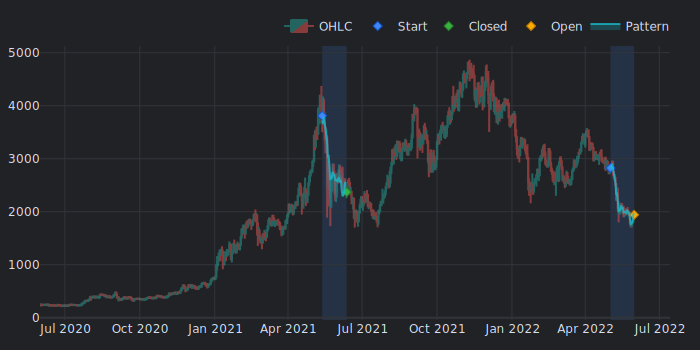

In [99]:
pattern_ranges.plot(column=("rebase", "last", "ETHUSDT")).show_svg()

#### Mask

In [100]:
mask = pattern_ranges.last_pd_mask
mask.sum()

rescale_mode  search_config  symbol 
minmax        double_top     BTCUSDT    6
                             ETHUSDT    4
              last           BTCUSDT    5
                             ETHUSDT    8
rebase        double_top     BTCUSDT    0
                             ETHUSDT    0
              last           BTCUSDT    2
                             ETHUSDT    2
dtype: int64

#### Indicator

In [101]:
pattern_ranges = price.vbt.find_pattern(
    pattern,
    window=30,
    max_window=120,
    row_select_prob=0.5,
    window_select_prob=0.5,
    overlap_mode="allow",
    seed=42
)
pr_mask = pattern_ranges.map_field(
    "similarity", 
    idx_arr=pattern_ranges.last_idx.values
).to_pd()
pr_mask[~pr_mask.isnull()]

Open time
2021-03-23 00:00:00+00:00    0.854189
2021-03-26 00:00:00+00:00    0.853817
2021-04-10 00:00:00+00:00    0.866913
2021-04-11 00:00:00+00:00    0.866106
2021-11-17 00:00:00+00:00    0.868276
2021-11-18 00:00:00+00:00    0.873757
2021-11-21 00:00:00+00:00    0.890225
2021-11-23 00:00:00+00:00    0.892541
2021-11-24 00:00:00+00:00    0.879475
2021-11-26 00:00:00+00:00    0.877245
2021-11-27 00:00:00+00:00    0.872172
dtype: float64

In [102]:
patsim = vbt.PATSIM.run(
    price,
    vbt.Default(pattern),
    window=vbt.Default(30),
    max_window=vbt.Default(120),
    row_select_prob=vbt.Default(0.5),
    window_select_prob=vbt.Default(0.5),
    min_similarity=vbt.Default(0.85),
    seed=42
)
ind_mask = patsim.similarity
ind_mask[~ind_mask.isnull()]

Open time
2021-03-23 00:00:00+00:00    0.854189
2021-03-26 00:00:00+00:00    0.853817
2021-04-10 00:00:00+00:00    0.866913
2021-04-11 00:00:00+00:00    0.866106
2021-11-17 00:00:00+00:00    0.868276
2021-11-18 00:00:00+00:00    0.873757
2021-11-21 00:00:00+00:00    0.890225
2021-11-23 00:00:00+00:00    0.892541
2021-11-24 00:00:00+00:00    0.879475
2021-11-26 00:00:00+00:00    0.877245
2021-11-27 00:00:00+00:00    0.872172
dtype: float64

### Combination

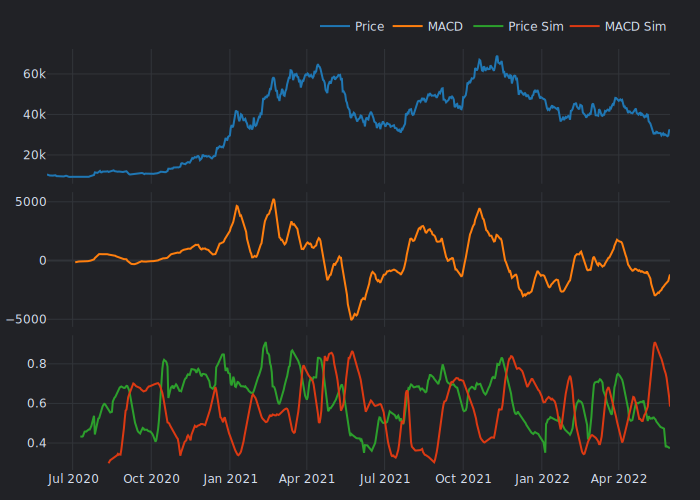

In [103]:
price_highs = vbt.PATSIM.run(
    data.high, 
    pattern=np.array([1, 3, 2, 4]), 
    window=40,
    max_window=50
)
macd = data.run("talib_macd").macd
macd_lows = vbt.PATSIM.run(
    macd, 
    pattern=np.array([4, 2, 3, 1]), 
    window=40,
    max_window=50
)

fig = vbt.make_subplots(
    rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02
)
fig.update_layout(height=500)
data.high.rename("Price").vbt.plot(
    add_trace_kwargs=dict(row=1, col=1), fig=fig
)
macd.rename("MACD").vbt.plot(
    add_trace_kwargs=dict(row=2, col=1), fig=fig
)
price_highs.similarity.rename("Price Sim").vbt.plot(
    add_trace_kwargs=dict(row=3, col=1), fig=fig
)
macd_lows.similarity.rename("MACD Sim").vbt.plot(
    add_trace_kwargs=dict(row=3, col=1), fig=fig
)
fig.show_svg()

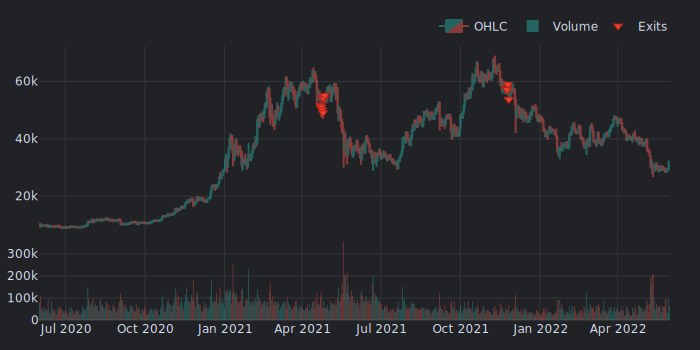

In [104]:
cond1 = (price_highs.similarity >= 0.8).vbt.rolling_any(10)
cond2 = (macd_lows.similarity >= 0.8).vbt.rolling_any(10)
exits = cond1 & cond2
fig = data.plot(ohlc_trace_kwargs=dict(opacity=0.5))
exits.vbt.signals.plot_as_exits(data.close, fig=fig).show_svg()

## Projections

In [105]:
pattern_ranges = price.vbt.find_pattern(
    [1, 1.2], 
    window=7, 
    rescale_mode="rebase", 
    max_error=0.01,
    max_error_interp_mode="discrete",
    max_error_strict=True
)
pattern_ranges.count()

3

### Pattern projections

In [106]:
range_idxs, raw_projections = vbt.nb.map_ranges_to_projections_nb(
    vbt.to_2d_array(price),
    pattern_ranges.get_field_arr("col"),
    pattern_ranges.get_field_arr("start_idx"),
    pattern_ranges.get_field_arr("end_idx"),
    pattern_ranges.get_field_arr("status")
)

In [107]:
range_idxs

array([0, 1, 2])

In [108]:
raw_projections

array([[1.        , 1.00936136, 1.0528197 , 1.11080047, 1.12247632,
        1.13616486, 1.18824968, 1.16303367],
       [1.        , 1.03041164, 1.07854881, 1.08766541, 1.14380648,
        1.17483528, 1.20173755, 1.11737666],
       [1.        , 1.02418635, 1.10605106, 1.12944688, 1.17161711,
        1.17323145, 1.20239992, 1.22269832]])

In [109]:
projections = pattern_ranges.get_projections()
print(projections)

range_id                          0         1         2
2022-05-31 00:00:00+00:00  1.000000  1.000000  1.000000
2022-06-01 00:00:00+00:00  1.009361  1.030412  1.024186
2022-06-02 00:00:00+00:00  1.052820  1.078549  1.106051
2022-06-03 00:00:00+00:00  1.110800  1.087665  1.129447
2022-06-04 00:00:00+00:00  1.122476  1.143806  1.171617
2022-06-05 00:00:00+00:00  1.136165  1.174835  1.173231
2022-06-06 00:00:00+00:00  1.188250  1.201738  1.202400
2022-06-07 00:00:00+00:00  1.163034  1.117377  1.222698


In [110]:
pattern_ranges.duration.values

array([7, 7, 7])

In [111]:
projections = pattern_ranges.get_projections(incl_end_idx=False)
print(projections)

range_id                          0         1         2
2022-05-31 00:00:00+00:00  1.000000  1.000000  1.000000
2022-06-01 00:00:00+00:00  1.009361  1.030412  1.024186
2022-06-02 00:00:00+00:00  1.052820  1.078549  1.106051
2022-06-03 00:00:00+00:00  1.110800  1.087665  1.129447
2022-06-04 00:00:00+00:00  1.122476  1.143806  1.171617
2022-06-05 00:00:00+00:00  1.136165  1.174835  1.173231
2022-06-06 00:00:00+00:00  1.188250  1.201738  1.202400


In [112]:
projections.iloc[-1] / projections.iloc[0] - 1

range_id
0    0.188250
1    0.201738
2    0.202400
dtype: float64

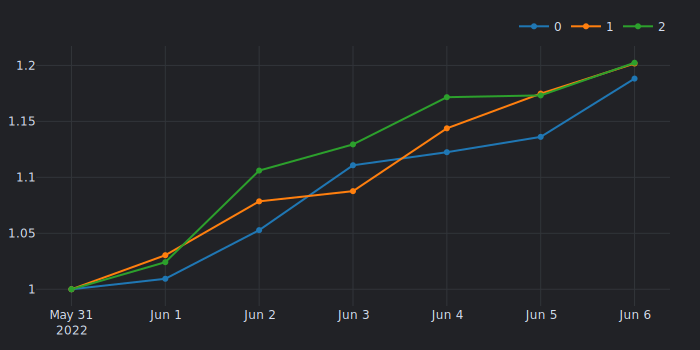

In [113]:
projections.vbt.plot().show_svg()

### Delta projections

In [114]:
delta_ranges = pattern_ranges.with_delta(4)

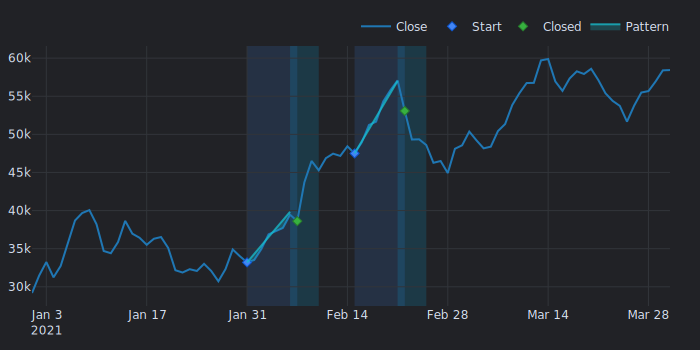

In [115]:
fig = pattern_ranges.loc["2021-01":"2021-03"].plot()
delta_ranges.loc["2021-01":"2021-03"].plot(
    plot_ohlc=False,
    plot_close=False,
    plot_markers=False,
    closed_shape_kwargs=dict(fillcolor="DeepSkyBlue"),
    fig=fig
).show_svg()

In [116]:
projections = delta_ranges.get_projections()
print(projections)

range_id                          0         1         2
2022-05-31 00:00:00+00:00  1.000000  1.000000  1.000000
2022-06-01 00:00:00+00:00  0.978779  0.929801  1.016882
2022-06-02 00:00:00+00:00  1.108145  0.864097  0.992104
2022-06-03 00:00:00+00:00  1.178824  0.864522  0.963215
2022-06-04 00:00:00+00:00  1.147739  0.851382  0.941327


In [117]:
np.mean(projections.iloc[-1] / projections.iloc[0] - 1)

-0.01985064245106242

In [118]:
pattern_ranges = mult_price.vbt.find_pattern(
    [1, 1.2], 
    window=7, 
    max_window=30,
    rescale_mode="rebase",
    max_error=0.01,
    max_error_interp_mode="discrete",
    max_error_strict=True,
    overlap_mode="allow"
)
pattern_ranges.count()

symbol
BTCUSDT    48
ETHUSDT    64
Name: count, dtype: int64

In [119]:
delta_ranges = pattern_ranges.with_delta(4)

In [120]:
projections = delta_ranges.get_projections()

In [121]:
(projections.iloc[-1] / projections.iloc[0] - 1).describe()

count    112.000000
mean       0.010467
std        0.079566
min       -0.203760
25%       -0.044565
50%        0.014051
75%        0.055390
max        0.270107
dtype: float64

In [122]:
projections = delta_ranges.get_projections(id_level="end_idx")

In [123]:
print(projections.columns)

MultiIndex([('BTCUSDT', '2020-08-03 00:00:00+00:00'),
            ('BTCUSDT', '2020-08-04 00:00:00+00:00'),
            ('BTCUSDT', '2020-08-05 00:00:00+00:00'),
            ('BTCUSDT', '2020-10-31 00:00:00+00:00'),
            ('BTCUSDT', '2020-11-04 00:00:00+00:00'),
            ('BTCUSDT', '2020-11-05 00:00:00+00:00'),
            ('BTCUSDT', '2020-11-12 00:00:00+00:00'),
            ('BTCUSDT', '2020-11-14 00:00:00+00:00'),
            ('BTCUSDT', '2020-11-15 00:00:00+00:00'),
            ('BTCUSDT', '2020-11-16 00:00:00+00:00'),
            ...
            ('ETHUSDT', '2022-03-29 00:00:00+00:00'),
            ('ETHUSDT', '2022-03-30 00:00:00+00:00'),
            ('ETHUSDT', '2022-03-31 00:00:00+00:00'),
            ('ETHUSDT', '2022-04-03 00:00:00+00:00'),
            ('ETHUSDT', '2022-04-04 00:00:00+00:00'),
            ('ETHUSDT', '2022-04-05 00:00:00+00:00'),
            ('ETHUSDT', '2022-04-06 00:00:00+00:00'),
            ('ETHUSDT', '2022-04-07 00:00:00+00:00'),
            

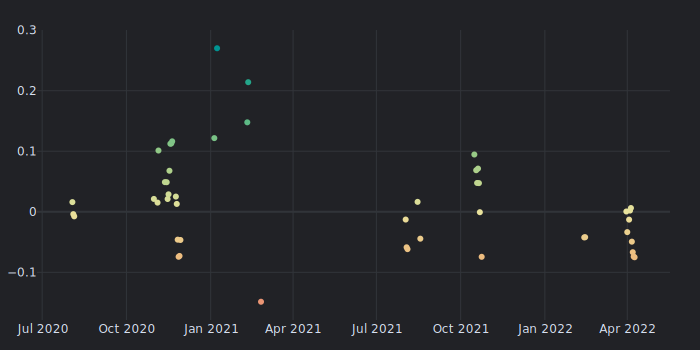

In [124]:
btc_projections = projections.xs("BTCUSDT", level="symbol", axis=1)
total_proj_return = btc_projections.iloc[-1] / btc_projections.iloc[0] - 1
total_proj_return.vbt.scatterplot(
    trace_kwargs=dict(
        marker=dict(
            color=total_proj_return.values,
            colorscale="Temps_r",
            cmid=0
        )
    )
).show_svg()

### Plotting

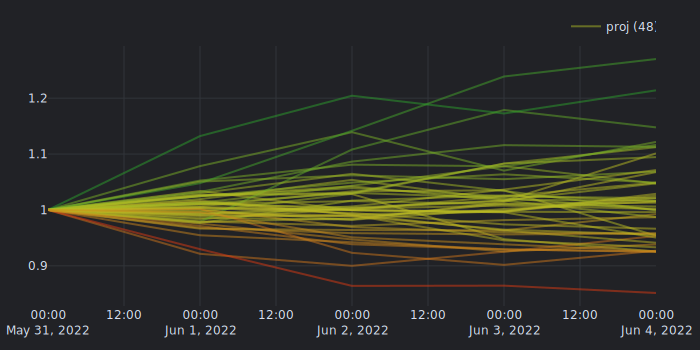

In [125]:
btc_projections.vbt.plot_projections(plot_bands=False).show_svg()

#### Colorization

In [126]:
btc_projections["2020-08-03"]

2022-05-31 00:00:00+00:00    1.000000
2022-06-01 00:00:00+00:00    1.019300
2022-06-02 00:00:00+00:00    1.053823
2022-06-03 00:00:00+00:00    1.018510
2022-06-04 00:00:00+00:00    1.015957
Freq: D, Name: 2020-08-03 00:00:00+00:00, dtype: float64

In [127]:
btc_projections["2020-08-03"].median()

1.018510232892989

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning:

The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



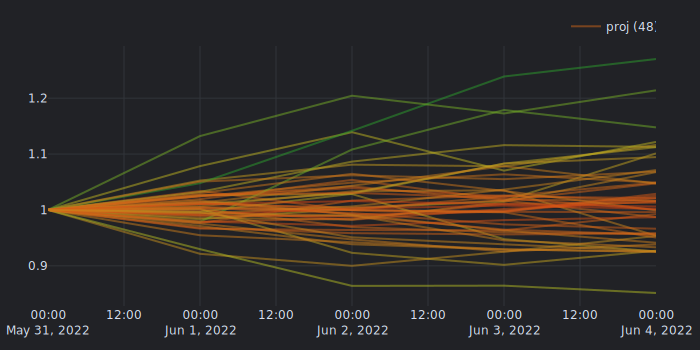

In [128]:
btc_projections.vbt.plot_projections(
    plot_bands=False, colorize=np.std
).show_svg()

#### Bands

In [129]:
projections.xs("ETHUSDT", level="symbol", axis=1).median(axis=1)

2022-05-31 00:00:00+00:00    1.000000
2022-06-01 00:00:00+00:00    1.005677
2022-06-02 00:00:00+00:00    1.014560
2022-06-03 00:00:00+00:00    1.017341
2022-06-04 00:00:00+00:00    1.019444
Freq: D, dtype: float64

In [130]:
print(projections.groupby("symbol", axis=1).median())

symbol                      BTCUSDT   ETHUSDT
2022-05-31 00:00:00+00:00  1.000000  1.000000
2022-06-01 00:00:00+00:00  1.003365  1.005677
2022-06-02 00:00:00+00:00  1.001214  1.014560
2022-06-03 00:00:00+00:00  1.010576  1.017341
2022-06-04 00:00:00+00:00  1.009568  1.019444


/tmp/ipykernel_433640/3072823874.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [131]:
projections.median(axis=1)

2022-05-31 00:00:00+00:00    1.000000
2022-06-01 00:00:00+00:00    1.004447
2022-06-02 00:00:00+00:00    1.006168
2022-06-03 00:00:00+00:00    1.014375
2022-06-04 00:00:00+00:00    1.014051
Freq: D, dtype: float64

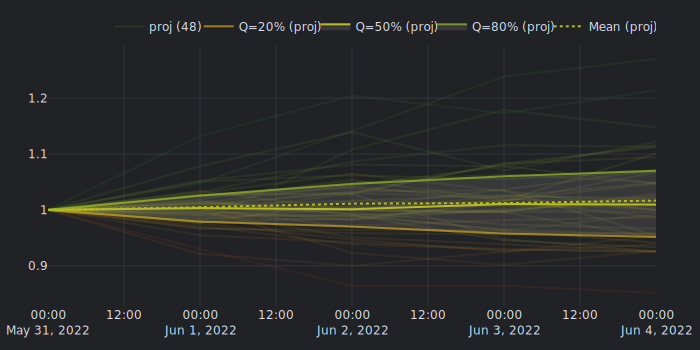

In [132]:
btc_projections.vbt.plot_projections().show_svg()

In [133]:
btc_projections.iloc[-1].quantile(0.8)

1.0702371602730685

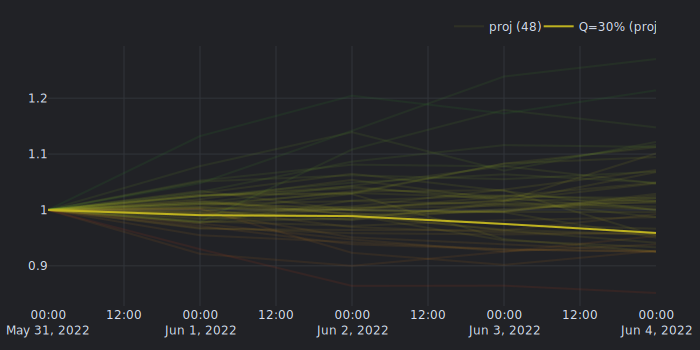

In [134]:
btc_projections.vbt.plot_projections(
    plot_lower=False,
    plot_middle="30%", 
    plot_upper=False, 
    plot_aux_middle=False, 
).show_svg()

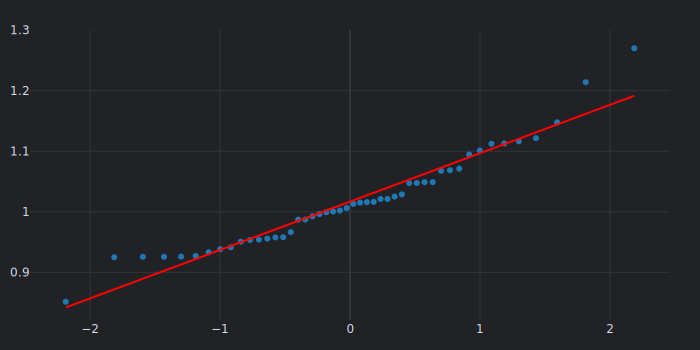

In [135]:
btc_projections.iloc[-1].vbt.qqplot().show_svg()

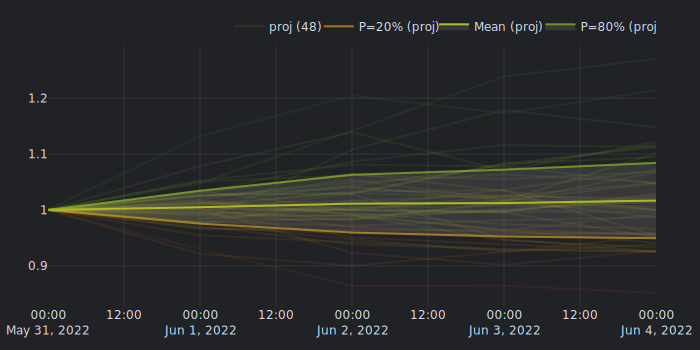

In [136]:
btc_projections.vbt.plot_projections(
    plot_lower="P=20%",
    plot_middle="mean", 
    plot_upper="P=80%", 
    plot_aux_middle=False, 
).show_svg()

/tmp/ipykernel_433640/559015782.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_433640/559015782.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



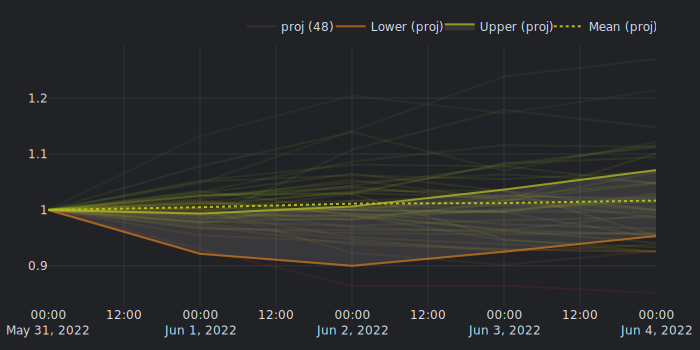

In [137]:
def finishes_at_quantile(df, q):
    nth_element = int(np.ceil(q * (df.shape[1] - 1)))
    nth_index = np.argsort(df.iloc[-1])[nth_element]
    return df.iloc[:, nth_index]

btc_projections.vbt.plot_projections(
    plot_lower=partial(finishes_at_quantile, q=0.2),
    plot_middle=False, 
    plot_upper=partial(finishes_at_quantile, q=0.8), 
).show_svg()

### Filtering

In [138]:
crossed_mask = projections.expanding().max().iloc[1] >= 1.05
filt_projections = projections.loc[:, crossed_mask]
filt_projections.iloc[-1].describe()

count    8.000000
mean     1.095870
std      0.084343
min      0.955078
25%      1.059109
50%      1.092623
75%      1.139190
max      1.214039
Name: 2022-06-04 00:00:00+00:00, dtype: float64

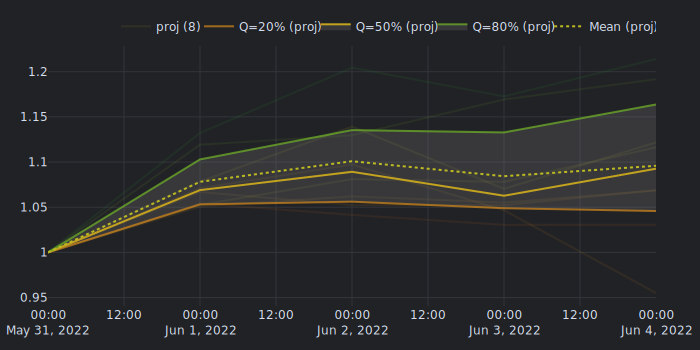

In [139]:
filt_projections.vbt.plot_projections().show_svg()

### Latest projections

In [140]:
pattern_ranges = price.vbt.find_pattern(
    pattern=data.close.iloc[-7:],
    rescale_mode="rebase",
    overlap_mode="allow"
)
pattern_ranges.count()

5

In [141]:
pattern_ranges = pattern_ranges.status_closed
pattern_ranges.count()

4

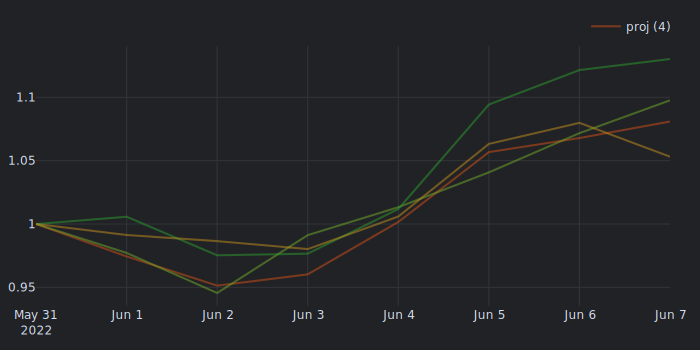

In [142]:
projections = pattern_ranges.get_projections()
projections.vbt.plot_projections(plot_bands=False).show_svg()

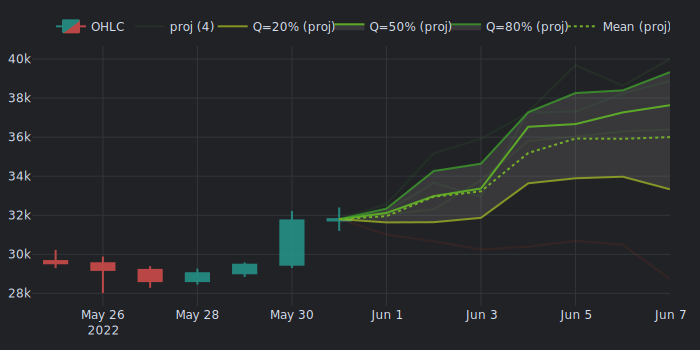

In [143]:
delta_ranges = pattern_ranges.with_delta(7)
projections = delta_ranges.get_projections(start_value=-1)
fig = data.iloc[-7:].plot(plot_volume=False)
projections.vbt.plot_projections(fig=fig).show_svg()

In [144]:
projections.mean(axis=1)

2022-05-31 00:00:00+00:00    31800.016667
2022-06-01 00:00:00+00:00    31954.384045
2022-06-02 00:00:00+00:00    32949.141986
2022-06-03 00:00:00+00:00    33226.167338
2022-06-04 00:00:00+00:00    35187.842799
2022-06-05 00:00:00+00:00    35927.559099
2022-06-06 00:00:00+00:00    35915.297291
2022-06-07 00:00:00+00:00    36001.916121
Freq: D, dtype: float64

In [145]:
next_data = vbt.BinanceData.pull(
    "BTCUSDT", 
    start="2022-05-31", 
    end="2022-06-08"
)
next_data.close

Open time
2022-05-31 00:00:00+00:00    31801.04
2022-06-01 00:00:00+00:00    29805.83
2022-06-02 00:00:00+00:00    30452.62
2022-06-03 00:00:00+00:00    29700.21
2022-06-04 00:00:00+00:00    29864.04
2022-06-05 00:00:00+00:00    29919.21
2022-06-06 00:00:00+00:00    31373.10
2022-06-07 00:00:00+00:00    31125.33
Freq: D, Name: Close, dtype: float64

#### Quick plotting

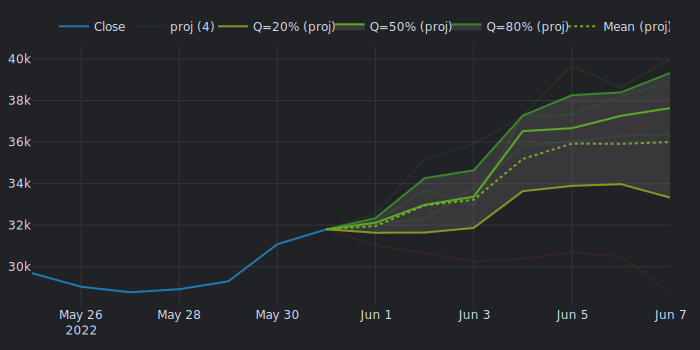

In [146]:
delta_ranges.plot_projections().show_svg()

### Non-uniform projections

In [147]:
windows = np.arange(10, 31)
window_tuples = combinations(windows, 2)
window_tuples = filter(lambda x: abs(x[0] - x[1]) >= 5, window_tuples)
fast_windows, slow_windows = zip(*window_tuples)
fast_sma = data.run("sma", fast_windows, short_name="fast_sma")
slow_sma = data.run("sma", slow_windows, short_name="slow_sma")
entries = fast_sma.real_crossed_above(slow_sma.real)
exits = fast_sma.real_crossed_below(slow_sma.real)

entries.shape

(730, 136)

In [148]:
entry_ranges = entries.vbt.signals.delta_ranges(30, close=data.close)
entry_ranges = entry_ranges.status_closed
entry_ranges.count().sum()

2233

In [149]:
exit_ranges = exits.vbt.signals.delta_ranges(30, close=data.close)
exit_ranges = exit_ranges.status_closed
exit_ranges.count().sum()

2233

In [150]:
entry_projections = entry_ranges.get_projections()
entry_projections.shape

(31, 2233)

In [151]:
exit_projections = exit_ranges.get_projections()
exit_projections.shape

(31, 2233)

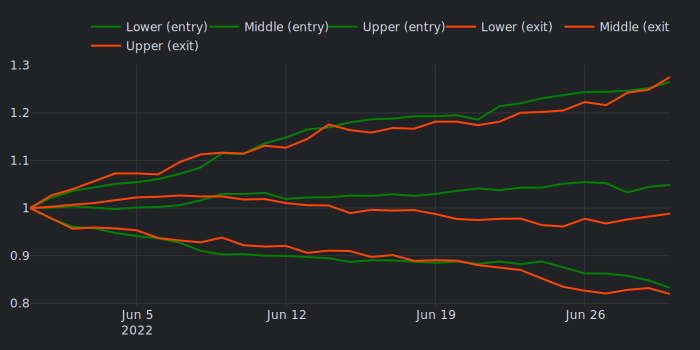

In [152]:
fig = entry_projections.vbt.plot_projections(
    plot_projections=False,
    lower_trace_kwargs=dict(name="Lower (entry)", line_color="green"),
    middle_trace_kwargs=dict(name="Middle (entry)", line_color="green"),
    upper_trace_kwargs=dict(name="Upper (entry)", line_color="green"),
    plot_aux_middle=False,
    plot_fill=False
)
fig = exit_projections.vbt.plot_projections(
    plot_projections=False,
    lower_trace_kwargs=dict(name="Lower (exit)", line_color="orangered"),
    middle_trace_kwargs=dict(name="Middle (exit)", line_color="orangered"),
    upper_trace_kwargs=dict(name="Upper (exit)", line_color="orangered"),
    plot_aux_middle=False,
    plot_fill=False,
    fig=fig
)
fig.show_svg()

In [153]:
entry_ranges = entries.vbt.signals.between_ranges(exits, close=data.close)
entry_ranges = entry_ranges.status_closed
entry_ranges.count().sum()

2240

In [154]:
exit_ranges = exits.vbt.signals.between_ranges(entries, close=data.close)
exit_ranges = exit_ranges.status_closed
exit_ranges.count().sum()

2118

In [155]:
entry_projections = entry_ranges.get_projections()
entry_projections.shape

(124, 2240)

In [156]:
exit_projections = exit_ranges.get_projections()
exit_projections.shape

(83, 2118)

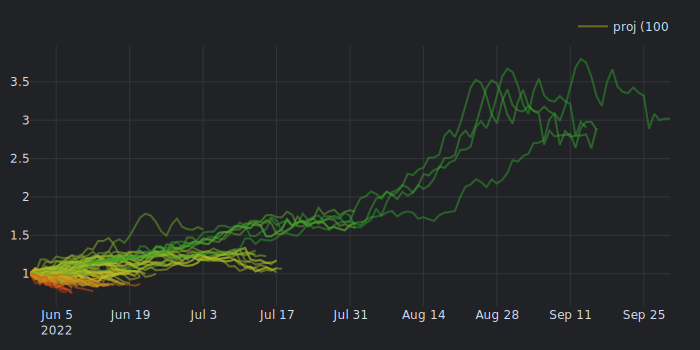

In [157]:
rand_cols = np.random.choice(entry_projections.shape[1], 100)
entry_projections.iloc[:, rand_cols].vbt.plot_projections(plot_bands=False).show_svg()

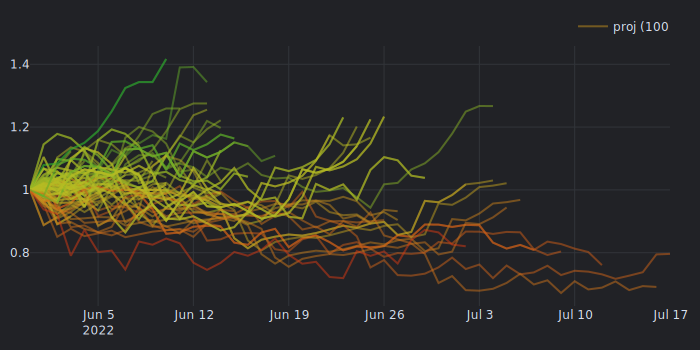

In [158]:
rand_cols = np.random.choice(exit_projections.shape[1], 100)
exit_projections.iloc[:, rand_cols].vbt.plot_projections(plot_bands=False).show_svg()

#### Shrinking

In [159]:
entry_projections = entry_ranges.get_projections(proj_period="30d")
entry_projections.shape

(31, 2240)

In [160]:
exit_projections = exit_ranges.get_projections(proj_period="30d")
exit_projections.shape

(31, 2118)

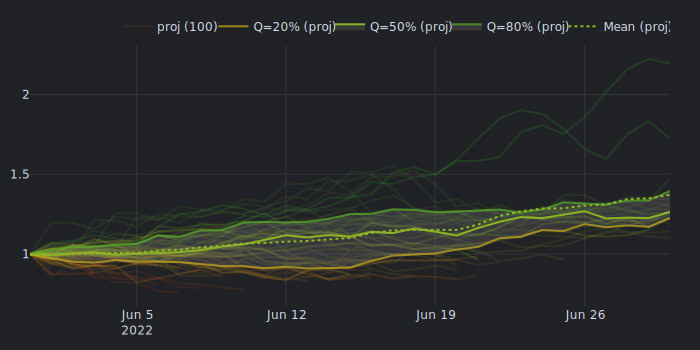

In [161]:
rand_cols = np.random.choice(entry_projections.shape[1], 100)
entry_projections.iloc[:, rand_cols].vbt.plot_projections().show_svg()

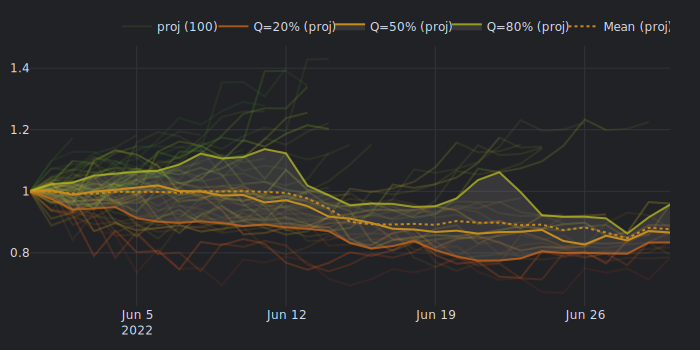

In [162]:
rand_cols = np.random.choice(exit_projections.shape[1], 100)
exit_projections.iloc[:, rand_cols].vbt.plot_projections().show_svg()

#### Stretching

In [163]:
entry_projections = entry_ranges.get_projections(
    proj_period="30d", extend=True
)
entry_projections.shape

(31, 2240)

In [164]:
exit_projections = exit_ranges.get_projections(
    proj_period="30d", extend=True
)
exit_projections.shape

(31, 2118)

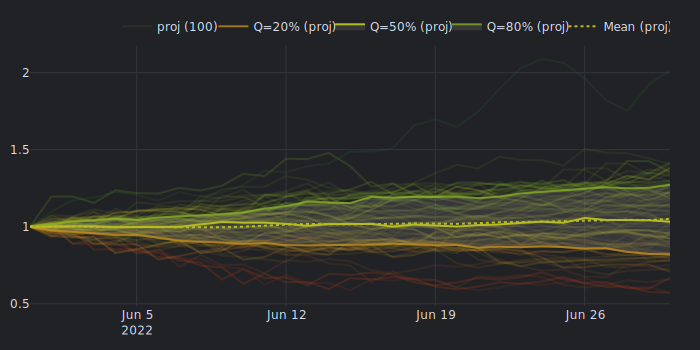

In [165]:
rand_cols = np.random.choice(entry_projections.shape[1], 100)
entry_projections.iloc[:, rand_cols].vbt.plot_projections().show_svg()

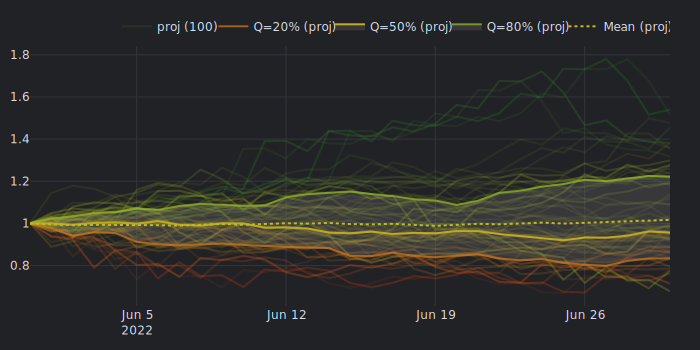

In [166]:
rand_cols = np.random.choice(exit_projections.shape[1], 100)
exit_projections.iloc[:, rand_cols].vbt.plot_projections().show_svg()

#### Quick plotting

In [167]:
entry_ranges.wrapper.columns

MultiIndex([(10, 15),
            (10, 16),
            (10, 17),
            (10, 18),
            (10, 19),
            (10, 20),
            (10, 21),
            (10, 22),
            (10, 23),
            (10, 24),
            ...
            (22, 27),
            (22, 28),
            (22, 29),
            (22, 30),
            (23, 28),
            (23, 29),
            (23, 30),
            (24, 29),
            (24, 30),
            (25, 30)],
           names=['fast_sma_timeperiod', 'slow_sma_timeperiod'], length=136)

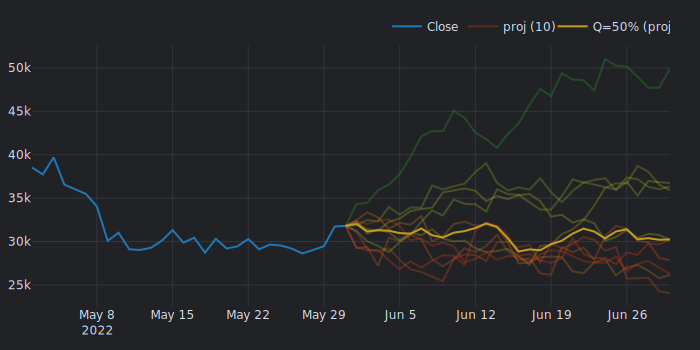

In [168]:
entry_ranges.plot_projections(
    column=(25, 30),
    last_n=10,
    proj_period="30d", 
    extend=True,
    plot_lower=False,
    plot_upper=False,
    plot_aux_middle=False,
    projection_trace_kwargs=dict(opacity=0.3)
).show_svg()

### Open projections

In [169]:
exit_ranges = exits.vbt.signals.between_ranges(
    entries, 
    incl_open=True, 
    close=data.close
)
exit_ranges.count().sum()

2240

In [170]:
exit_ranges.wrapper.columns[exit_ranges.status_open.col_arr]

MultiIndex([(10, 17),
            (10, 18),
            (10, 19),
            (10, 24),
            (10, 25),
            (10, 26),
            (10, 27),
            (10, 28),
            (10, 29),
            (10, 30),
            ...
            (22, 27),
            (22, 28),
            (22, 29),
            (22, 30),
            (23, 28),
            (23, 29),
            (23, 30),
            (24, 29),
            (24, 30),
            (25, 30)],
           names=['fast_sma_timeperiod', 'slow_sma_timeperiod'], length=122)

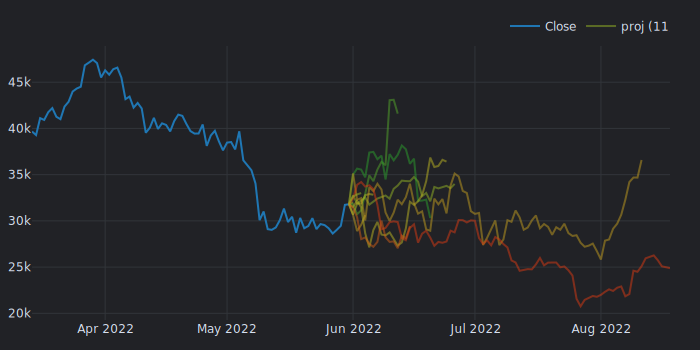

In [171]:
exit_ranges.status_closed.plot_projections(
    column=(20, 30), plot_bands=False
).show_svg()

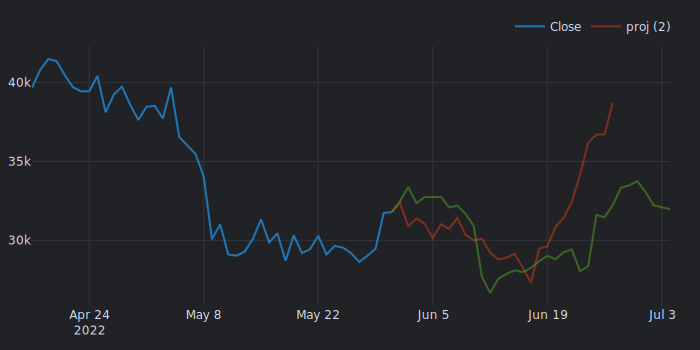

In [172]:
exit_ranges.plot_projections(
    column=(20, 30), plot_bands=False
).show_svg()

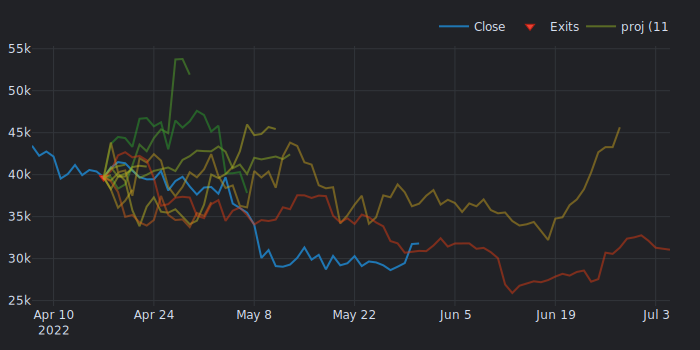

In [173]:
column = (20, 30)
signal_index = data.wrapper.index[np.flatnonzero(exits[column])[-1]]
plot_start_index = signal_index - pd.Timedelta(days=10)
sub_close = data.close[plot_start_index:]
sub_exits = exits.loc[plot_start_index:, column]

fig = sub_close.vbt.plot()
sub_exits.vbt.signals.plot_as_exits(sub_close, fig=fig)
projections = exit_ranges[column].status_closed.get_projections(
    start_value=sub_close.loc[signal_index],
    start_index=signal_index
)
projections.vbt.plot_projections(plot_bands=False, fig=fig).show_svg()